# Redshift Cluster using the AWS python SDK: Infrastructure-as-code

In [1]:
import os
import pandas as pd
import boto3
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Establish Datawarehouse Parameters

In [2]:
SPARKIFY_DWH_CLUSTER_TYPE=os.environ.get('SPARKIFY_DWH_CLUSTER_TYPE')
SPARKIFY_DWH_NUM_NODES=os.environ.get('SPARKIFY_DWH_NUM_NODES')
SPARKIFY_DWH_NODE_TYPE=os.environ.get('SPARKIFY_DWH_NODE_TYPE')

SPARKIFY_DWH_CLUSTER=os.environ.get('SPARKIFY_DWH_CLUSTER')
SPARKIFY_DB_NAME=os.environ.get('SPARKIFY_DB_NAME')
SPARKIFY_DB_USER=os.environ.get('SPARKIFY_DB_USER')
SPARKIFY_DB_PASSWORD=os.environ.get('SPARKIFY_DB_PASSWORD')
SPARKIFY_DB_PORT=os.environ.get('SPARKIFY_DB_PORT')

SPARKIFY_ARN=os.environ.get('SPARKIFY_ARN')

SPARKIFY_AWS_ACCESS_KEY_ID=os.environ.get('SPARKIFY_AWS_ACCESS_KEY_ID')
SPARKIFY_AWS_SECRET_ACCESS_KEY=os.environ.get('SPARKIFY_AWS_SECRET_ACCESS_KEY')

pd.DataFrame({"Param":
                  ["SPARKIFY_DWH_CLUSTER_TYPE", "SPARKIFY_DWH_NUM_NODES", "SPARKIFY_DWH_NODE_TYPE", 
                   "SPARKIFY_DWH_CLUSTER", "SPARKIFY_DB_NAME", "SPARKIFY_DB_USER", 
                   "SPARKIFY_DB_PORT", "SPARKIFY_ARN"],
              "Value":
                  [SPARKIFY_DWH_CLUSTER_TYPE, SPARKIFY_DWH_NUM_NODES, SPARKIFY_DWH_NODE_TYPE, 
                   '****', '****', SPARKIFY_DB_USER, 
                   SPARKIFY_DB_PORT, '****']
             })

,Param,Value
0,SPARKIFY_DWH_CLUSTER_TYPE,multi-node
1,SPARKIFY_DWH_NUM_NODES,4
2,SPARKIFY_DWH_NODE_TYPE,dc2.large
3,SPARKIFY_DWH_CLUSTER,****
4,SPARKIFY_DB_NAME,****
5,SPARKIFY_DB_USER,awsuser
6,SPARKIFY_DB_PORT,5439
7,SPARKIFY_ARN,****


# Create clients for IAM, EC2, S3 and Redshift

In [3]:
import boto3

ec2 = boto3.resource('ec2',
                       region_name="us-west-2",
                       aws_access_key_id=SPARKIFY_AWS_ACCESS_KEY_ID,
                       aws_secret_access_key=SPARKIFY_AWS_SECRET_ACCESS_KEY
                    )

s3 = boto3.resource('s3',
                       region_name="us-west-2",
                       aws_access_key_id=SPARKIFY_AWS_ACCESS_KEY_ID,
                       aws_secret_access_key=SPARKIFY_AWS_SECRET_ACCESS_KEY
                   )

iam = boto3.client('iam',aws_access_key_id=SPARKIFY_AWS_ACCESS_KEY_ID,
                     aws_secret_access_key=SPARKIFY_AWS_SECRET_ACCESS_KEY,
                     region_name='us-west-2'
                  )

redshift = boto3.client('redshift',
                       region_name="us-west-2",
                       aws_access_key_id=SPARKIFY_AWS_ACCESS_KEY_ID,
                       aws_secret_access_key=SPARKIFY_AWS_SECRET_ACCESS_KEY
                       )

# Investigate udacity-dend s3 bucket

In [4]:
bucket=s3.Bucket('udacity-dend')
log_data_files = [o.key for o in bucket.objects.filter(Prefix='log-data')]
print ("Number of files in log-data:",len(log_data_files)-1)
log_data_files[1:5]

('Number of files in log-data:', 30)


[u'log-data/2018/11/2018-11-01-events.json',
 u'log-data/2018/11/2018-11-02-events.json',
 u'log-data/2018/11/2018-11-03-events.json',
 u'log-data/2018/11/2018-11-04-events.json']

In [5]:
song_data_files = [o.key for o in bucket.objects.filter(Prefix='song-data/A/A')]
print ("Number of files in song-data in /A/A:",len(song_data_files)-1)
print ("26 * 26 * 600 = "+ str(26*26*600) + " Files in song-data")
song_data_files[1:5]

('Number of files in song-data in /A/A:', 603)
26 * 26 * 600 = 405600 Files in song-data


[u'song-data/A/A/A/TRAAAAV128F421A322.json',
 u'song-data/A/A/A/TRAAABD128F429CF47.json',
 u'song-data/A/A/A/TRAAACN128F9355673.json',
 u'song-data/A/A/A/TRAAAEA128F935A30D.json']

# STEP1: IAM ROLE
- Create an IAM Role that makes Redshift able to access S3 bucket (ReadOnly)

In [37]:
from botocore.exceptions import ClientError

IAM_ROLE_NAME=SPARKIFY_ARN.split('/')[-1]

#1.1 Create the role, 
try:
    print("1.1 Creating a new IAM Role") 
    dwhRole = iam.create_role(
        Path='/',
        RoleName=IAM_ROLE_NAME,
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole',
               'Effect': 'Allow',
               'Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )    
except Exception as e:
    print(e)
    
    
print("1.2 Attaching Policy")

iam.attach_role_policy(RoleName=IAM_ROLE_NAME,
                       PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                      )['ResponseMetadata']['HTTPStatusCode']

print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName=IAM_ROLE_NAME)['Role']['Arn']

print(roleArn)

# STEP2:  Redshift Cluster

- Create a RedShift Cluster
- For complete arguments to `create_cluster`, see [docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/redshift.html#Redshift.Client.create_cluster)

In [26]:
try:
    response = redshift.create_cluster(        
        #Cluster Specs
        ClusterType=SPARKIFY_DWH_CLUSTER_TYPE,
        NodeType=SPARKIFY_DWH_NODE_TYPE,
        NumberOfNodes=int(SPARKIFY_DWH_NUM_NODES),

        #Identifiers & Credentials
        DBName=SPARKIFY_DB_NAME,
        ClusterIdentifier=SPARKIFY_DWH_CLUSTER,
        MasterUsername=SPARKIFY_DB_USER,
        MasterUserPassword=SPARKIFY_DB_PASSWORD,
        
        #Roles (for s3 access)
        IamRoles=[SPARKIFY_ARN]  
    )
except Exception as e:
#     print(e)
    print('Confirming READONLY Privileges')

Confirming READONLY Privileges


## Check Cluster Status, Ensure Available

In [5]:
cluster_properties = redshift.describe_clusters(ClusterIdentifier=SPARKIFY_DWH_CLUSTER)['Clusters'][0]
cols = ["ClusterIdentifier", "NodeType", "ClusterStatus", 
        "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']

pd.DataFrame([(col,cluster_properties[col]) 
              if col not in ['MasterUsername', 'DBName', 'Endpoint', 'VpcId']
              else (col,'****') for col in cols],
             columns=['Key', 'Value'])

,Key,Value
0,ClusterIdentifier,sparkify-redshift-cluster
1,NodeType,dc2.large
2,ClusterStatus,available
3,MasterUsername,****
4,DBName,****
5,Endpoint,****
6,NumberOfNodes,4
7,VpcId,****


In [6]:
DB_ENDPOINT = cluster_properties['Endpoint']['Address']
DB_ROLE_ARN = cluster_properties['IamRoles'][0]['IamRoleArn']
print("DWH_ENDPOINT :: "+'****')
print("DWH_ROLE_ARN :: "+'****')

DWH_ENDPOINT :: ****
DWH_ROLE_ARN :: ****


# Allow Access To Cluster Endpoint By Opening Incoming TCP Port

In [118]:
try:
    vpc = ec2.Vpc(id=cluster_properties['VpcId'])
    defaultSg = list(vpc.security_groups.all())[0]
    print(defaultSg)
    defaultSg.authorize_ingress(
        GroupName=defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(SPARKIFY_DB_PORT),
        ToPort=int(SPARKIFY_DB_PORT)
    )
except Exception as e:
    print(e)

# Check Connection To Cluster

In [7]:
%load_ext sql

In [9]:
conn_string="postgresql://{}:{}@{}:{}/{}".format(SPARKIFY_DB_USER, SPARKIFY_DB_PASSWORD, 
                                                 DB_ENDPOINT, SPARKIFY_DB_PORT, SPARKIFY_DB_NAME)
# %sql $conn_string

## Star Schema

<img src="./images/star_schema.png" width="50%"/>

## CUBE Queries

In [12]:
%%sql results <<
SELECT u.gender, count(u.gender)
FROM users as u
JOIN songplays as sp ON (sp.user_id = u.user_id)
JOIN artists as a ON (a.artist_id = sp.artist_id)
WHERE a.artist_name = 'Muse'
group by u.gender

In [11]:
results

gender,count
M,9
F,48


In [15]:
%%sql results << 
SELECT u.gender, count(u.gender)
FROM users as u
group by u.gender

In [14]:
results

gender,count
F,60
M,45


In [18]:
%%sql results << 
SELECT u.gender, sp.level, count(sp.level) as level_count
FROM songplays as sp
JOIN users as u ON (u.user_id = sp.user_id)
JOIN artists as a ON (a.artist_id = sp.artist_id)
WHERE a.artist_name = 'Muse'
group by u.gender, sp.level
order by level_count desc

In [17]:
results

gender,level,level_count
F,paid,44
M,paid,9
F,free,4


In [20]:
%%sql results << 
SELECT a.artist_name, count(a.artist_name) as artists_split
FROM songplays as sp 
JOIN songs as s ON (s.song_id = sp.song_id)
JOIN artists as a ON (a.artist_id = sp.artist_id)
group by a.artist_name
order by artists_split desc
limit 20;

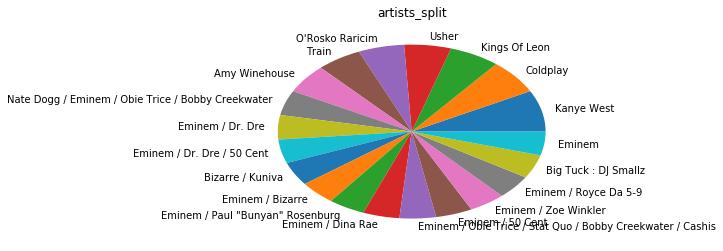

In [21]:
results.pie();

# DELETE CLUSTER AND REMOVE IAM ROLE
## <font color='red'>Caution When Running These Cells

In [18]:
# redshift.delete_cluster(ClusterIdentifier=SPARKIFY_DWH_CLUSTER,  SkipFinalClusterSnapshot=True)

In [19]:
# cluster_properties = redshift.describe_clusters(ClusterIdentifier=SPARKIFY_DWH_CLUSTER)['Clusters'][0]
# cols = ["ClusterIdentifier", "NodeType", "ClusterStatus", 
#         "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']

# pd.DataFrame([(col,cluster_properties[col]) 
#               if col not in ['MasterUsername', 'DBName', 'Endpoint', 'VpcId']
#               else (col,'****') for col in cols],
#              columns=['Key', 'Value'])

In [20]:
# iam.detach_role_policy(RoleName=SPARKIFY_ARN, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")
# iam.delete_role(RoleName=SPARKIFY_ARN)